In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00


# Train the Model on DocLayNet dataset subset that I Created and on microsoft DiT-Base

In [ ]:
import numpy as np
import cv2
from datasets import load_dataset
from transformers import AutoImageProcessor, BeitForSemanticSegmentation, TrainingArguments, Trainer
from PIL import Image
import torch
import os

# 1. Load the dataset
dataset = load_dataset("nevernever69/small-DocLayNet-v1.1")

# 2. Load image processor and model
image_processor = AutoImageProcessor.from_pretrained("microsoft/dit-base", num_labels=11)
model = BeitForSemanticSegmentation.from_pretrained("microsoft/dit-base", num_labels=11)

# 3. Define preprocessing functions
def create_segmentation_mask(example):
    """Create a segmentation mask from COCO-style annotations."""
    num_classes = 11
    H, W = 1025, 1025

    # Initialize a single-channel mask for semantic segmentation
    # For semantic segmentation, we need class indices, not one-hot encoding
    mask = np.zeros((H, W), dtype=np.int64)

    if "bboxes" in example and "category_id" in example:
        for bbox, cat in zip(example["bboxes"], example["category_id"]):
            x, y, w, h = map(int, bbox)
            x = np.clip(x, 0, W)
            y = np.clip(y, 0, H)
            w = np.clip(w, 0, W - x)
            h = np.clip(h, 0, H - y)
            # Assign the class index to the mask (subtract 1 to make it 0-indexed)
            mask[y:y+h, x:x+w] = cat - 1

    # Resize mask to the target resolution (e.g., 56x56)
    target_size = (56, 56)
    resized_mask = cv2.resize(mask, dsize=target_size, interpolation=cv2.INTER_NEAREST)

    return resized_mask

# 4. Data collator that handles preprocessing during training
def collate_fn(examples):
    """Process a batch of examples for training."""
    # Process images
    images = []
    labels = []

    for example in examples:
        # Open and convert image
        image_path = example["image"]
        if isinstance(image_path, str) and os.path.exists(image_path):
            image = Image.open(image_path).convert("RGB")
        else:
            # If image is already a PIL Image
            image = image_path if isinstance(image_path, Image.Image) else None

        if image is None:
            raise ValueError(f"Could not open image: {image_path}")

        images.append(image)

        # Create segmentation mask
        mask = create_segmentation_mask(example)
        labels.append(mask)

    # Process images with image processor
    inputs = image_processor(images=images, return_tensors="pt")

    # Add labels to inputs - BeitForSemanticSegmentation expects class indices
    # not class probabilities, so we need to use Long tensor
    inputs["labels"] = torch.tensor(np.array(labels), dtype=torch.long)

    return inputs

# 5. Keep only necessary columns (we need to keep image and annotation data for mask creation)
columns_to_keep = ["image", "bboxes", "category_id"]
dataset = dataset.select_columns(columns_to_keep)

# 6. Set training arguments
training_args = TrainingArguments(
    output_dir="./dit-base-doclaynet",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    save_steps=1000,
    logging_steps=100,
    learning_rate=5e-5,
    weight_decay=0.01,
    fp16=True,
    remove_unused_columns=False,
)

# 7. Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=collate_fn,
)

# 8. Start training
trainer.train()

Some weights of BeitForSemanticSegmentation were not initialized from the model checkpoint at microsoft/dit-base and are newly initialized: ['auxiliary_head.classifier.bias', 'auxiliary_head.classifier.weight', 'auxiliary_head.convs.0.bn.bias', 'auxiliary_head.convs.0.bn.num_batches_tracked', 'auxiliary_head.convs.0.bn.running_mean', 'auxiliary_head.convs.0.bn.running_var', 'auxiliary_head.convs.0.bn.weight', 'auxiliary_head.convs.0.conv.weight', 'decode_head.bottleneck.bn.bias', 'decode_head.bottleneck.bn.num_batches_tracked', 'decode_head.bottleneck.bn.running_mean', 'decode_head.bottleneck.bn.running_var', 'decode_head.bottleneck.bn.weight', 'decode_head.bottleneck.conv.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.fpn_bottleneck.bn.bias', 'decode_head.fpn_bottleneck.bn.num_batches_tracked', 'decode_head.fpn_bottleneck.bn.running_mean', 'decode_head.fpn_bottleneck.bn.running_var', 'decode_head.fpn_bottleneck.bn.weight', 'decode_head.fpn_bottle

Step,Training Loss,Validation Loss
500,0.582900,0.559867


TrainOutput(global_step=500, training_loss=0.8804892044067383, metrics={'train_runtime': 352.6231, 'train_samples_per_second': 11.344, 'train_steps_per_second': 1.418, 'total_flos': 5.87125290221568e+17, 'train_loss': 0.8804892044067383, 'epoch': 2.0})

# Test Documents Layout Detection on Trained Model after 2 ephocs

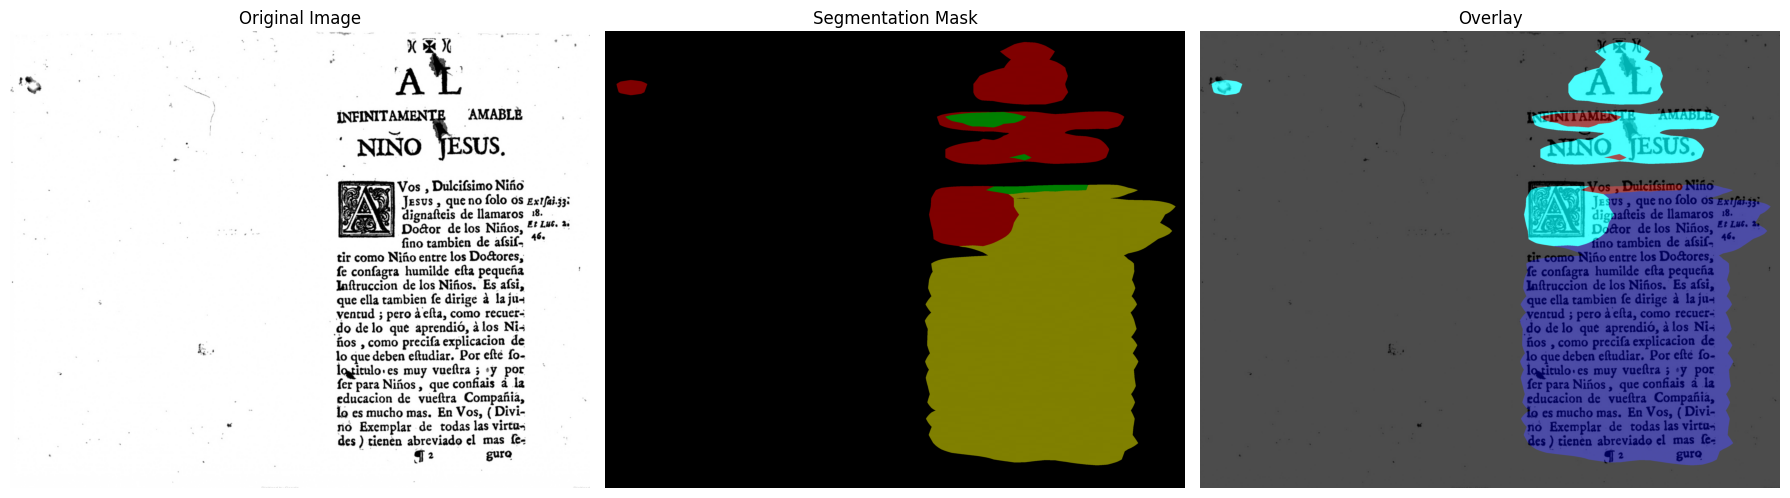

Detected document elements:
  - Background: 74.12% of the document
  - Header: 5.89% of the document
  - Footer: 0.57% of the document
  - Footnote: 19.41% of the document


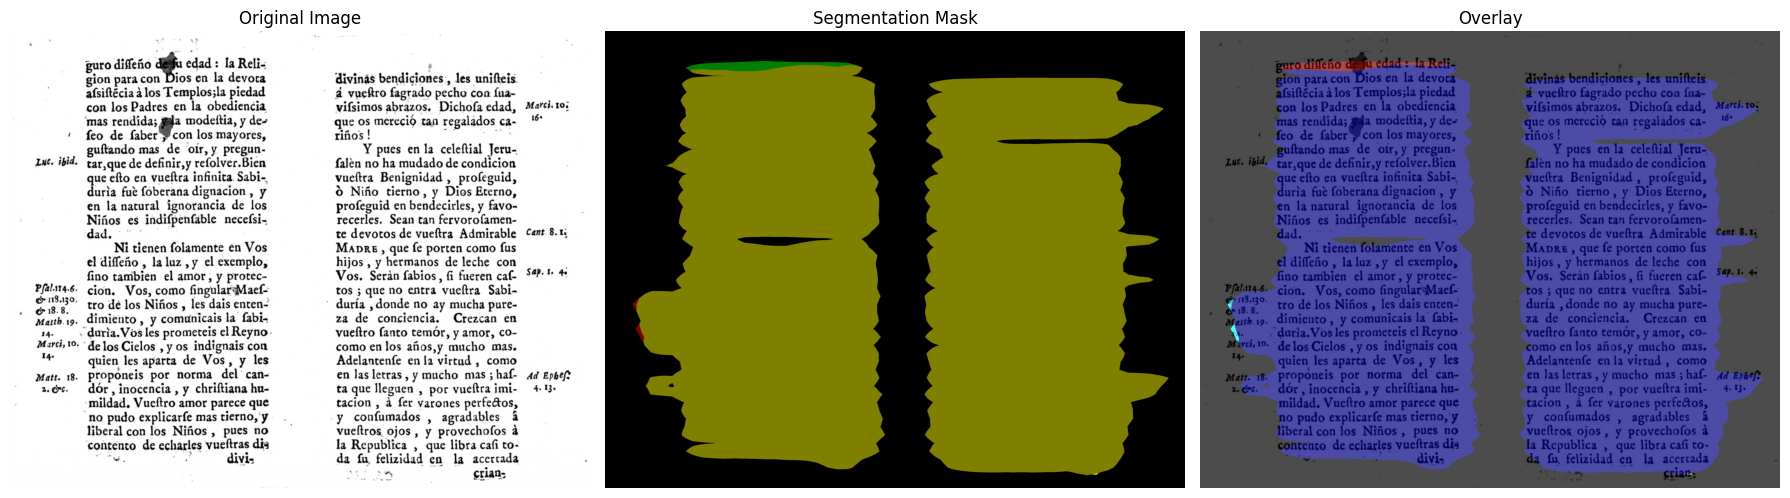

Detected document elements:
  - Background: 40.77% of the document
  - Table: 0.00% of the document
  - Header: 0.03% of the document
  - Footer: 0.37% of the document
  - Footnote: 58.83% of the document


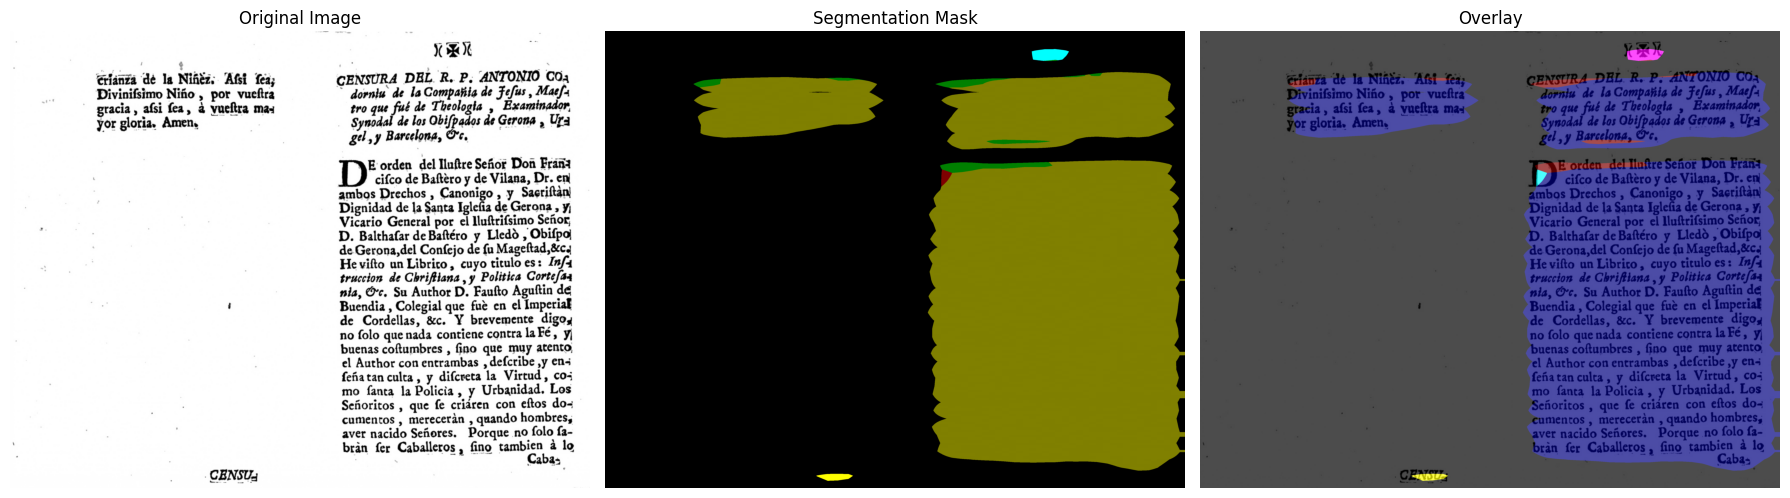

Detected document elements:
  - Background: 63.29% of the document
  - Table: 0.07% of the document
  - List: 0.13% of the document
  - Header: 0.04% of the document
  - Footer: 0.55% of the document
  - Footnote: 35.92% of the document


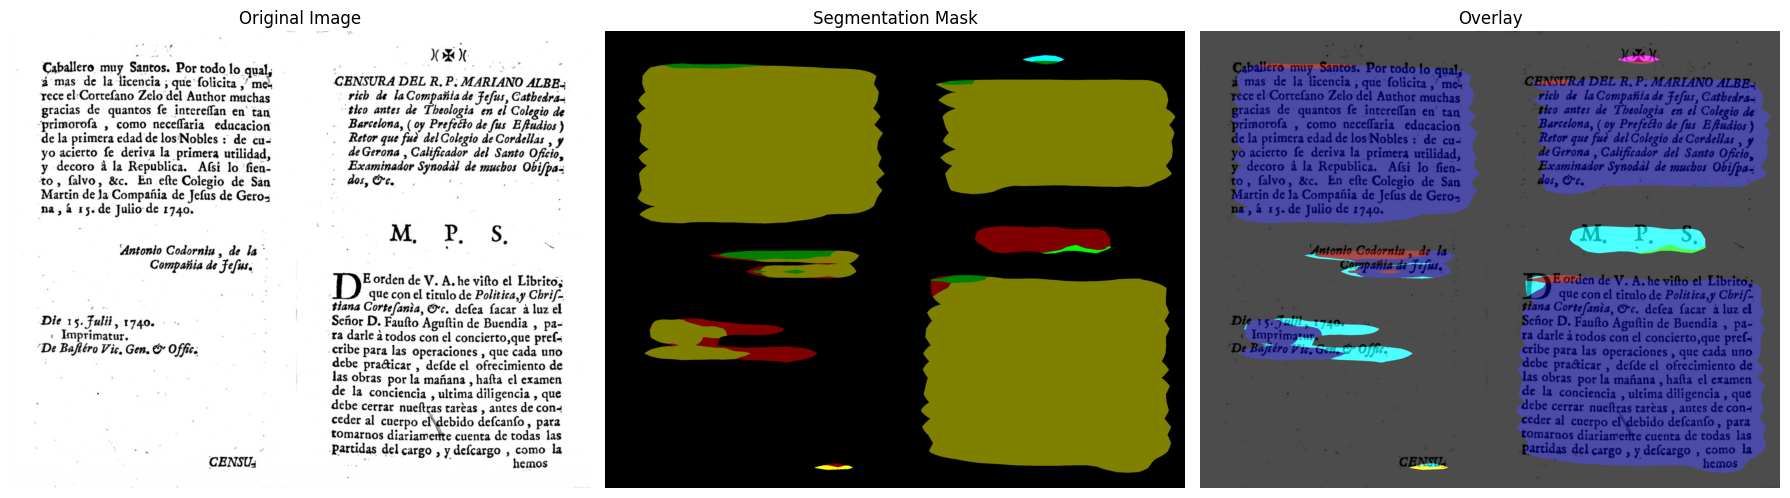

Detected document elements:
  - Background: 56.44% of the document
  - Paragraph: 0.08% of the document
  - Table: 0.04% of the document
  - List: 0.07% of the document
  - Header: 2.05% of the document
  - Footer: 0.65% of the document
  - Footnote: 40.67% of the document


In [11]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2
from transformers import AutoImageProcessor, BeitForSemanticSegmentation

# 1. Load the trained model and image processor
model_path = "nevernever69/dit-doclaynet-segmentation"  # Path to your saved model
image_processor = AutoImageProcessor.from_pretrained("nevernever69/dit-doclaynet-segmentation", num_labels=11)
model = BeitForSemanticSegmentation.from_pretrained(model_path)

# Put model in evaluation mode
model.eval()

# 2. Define a function to visualize the segmentation results
def visualize_segmentation(image, mask, alpha=0.7):
    """
    Visualize the segmentation mask overlaid on the original image.

    Args:
        image: PIL Image or path to image
        mask: numpy array of shape (H, W) with class indices
        alpha: transparency of the overlay
    """
    # Ensure image is a PIL Image
    if isinstance(image, str):
        image = Image.open(image).convert("RGB")

    # Convert image to numpy array
    img_np = np.array(image)

    # Create a colormap for visualization (11 classes)
    colors = [
        [0, 0, 0],       # 0: Background - black
        [255, 0, 0],     # 1: Title - red
        [0, 255, 0],     # 2: Paragraph - green
        [0, 0, 255],     # 3: Figure - blue
        [255, 255, 0],   # 4: Table - yellow
        [255, 0, 255],   # 5: List - magenta
        [0, 255, 255],   # 6: Header - cyan
        [128, 0, 0],     # 7: Footer - dark red
        [0, 128, 0],     # 8: Page number - dark green
        [0, 0, 128],     # 9: Footnote - dark blue
        [128, 128, 0]    # 10: Caption - olive
    ]

    # Create a colormap
    cmap = ListedColormap(np.array(colors) / 255.0)

    # Create a colored mask
    colored_mask = cmap(mask)

    # Resize the mask to the image size
    h, w = img_np.shape[:2]
    resized_mask = cv2.resize(colored_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    # Overlay the mask on the image
    overlay = img_np.copy()
    overlay = (overlay * (1 - alpha) + resized_mask[:, :, :3] * 255 * alpha).astype(np.uint8)

    # Plot the original image and the overlay
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    ax1.imshow(img_np)
    ax1.set_title("Original Image")
    ax1.axis("off")

    ax2.imshow(mask, cmap=cmap)
    ax2.set_title("Segmentation Mask")
    ax2.axis("off")

    ax3.imshow(overlay)
    ax3.set_title("Overlay")
    ax3.axis("off")

    plt.tight_layout()
    plt.show()

    # Return the visualization for further use if needed
    return overlay

# 3. Function to run inference on a new image
def segment_document(image_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Perform document layout segmentation on a new image.

    Args:
        image_path: Path to the image to segment
        device: Device to run inference on ("cuda" or "cpu")

    Returns:
        PIL Image, segmentation mask
    """
    # Load the image
    image = Image.open(image_path).convert("RGB")

    # Move model to device
    model.to(device)

    # Preprocess the image
    inputs = image_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Perform inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted segmentation mask
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False
    )

    # Convert to class indices
    predicted_mask = upsampled_logits.argmax(dim=1).squeeze(0).cpu().numpy()

    # Visualize the results
    overlay = visualize_segmentation(image, predicted_mask)

    return image, predicted_mask, overlay

# 4. Example usage
if __name__ == "__main__":
    # Replace with your test image path
    for i in range(1, 5):
      test_image_path = f"Buendia - Instruccion_page-{i:04d}.jpg"

    # Run segmentation
      image, mask, overlay = segment_document(test_image_path)

    # You can also save the results
    # overlay_pil = Image.fromarray(overlay)
    # overlay_pil.save("segmentation_result.jpg")

    # Class names for reference
      class_names = [
        "Background",
        "Title",
        "Paragraph",
        "Figure",
        "Table",
        "List",
        "Header",
        "Footer",
        "Page number",
        "Footnote",
        "Caption"
      ]

    # Print statistics about the segmentation
      unique_classes = np.unique(mask)
      print("Detected document elements:")
      for cls in unique_classes:
          pixel_count = np.sum(mask == cls)
          percentage = (pixel_count / mask.size) * 100
          print(f"  - {class_names[cls]}: {percentage:.2f}% of the document")